# Double inverted pendulum

In this Jupyter Notebook we illustrate the example **DIP**. This example illustrates how to use **DAE** models in **do-mpc**.

**Open an interactive online Jupyter Notebook with this content on Binder:**

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/do-mpc/do-mpc/master?labpath=%2Fdocumentation%2Fsource%2Fexample_gallery%2FDIP.ipynb)


The example consists of the three modules **template_model.py**, which describes the system model, **template_mpc.py**, which defines the settings for the control and **template_simulator.py**, which sets the parameters for the simulator.
The modules are used in **main.py** for the closed-loop execution of the controller.

We start by importing basic modules and **do-mpc**.

In [1]:
import numpy as np
import sys
from casadi import *

# Add do_mpc to path. This is not necessary if it was installed via pip
import os
rel_do_mpc_path = os.path.join('..','..','..')
sys.path.append(rel_do_mpc_path)

# Import do_mpc package:
import do_mpc

c:\Users\Vatsh Van\AppData\Local\Programs\Python\Python311\Lib\site-packages\do_mpc\sysid\__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
c:\Users\Vatsh Van\AppData\Local\Programs\Python\Python311\Lib\site-packages\do_mpc\opcua\__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


## Model

In the following we will present the configuration, setup and connection between these blocks, starting with the `model`. 

In this example we consider the double pendulum on a card as depicted below:


<img src="dip_sketch.svg" width="60%">

The system is described in terms of its horizontal position $x$ and the two angles $\theta$, where $\theta_1 = \theta_2 = 0$ denotes the upright position.

We will formulate a continuous dynamic model for this system and start by initiating a **do-mpc** ``Model`` instance:

In [2]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

### Parameters

The model is configured with the following (certain) parameters:

In [3]:
m0 = 0.6  # kg, mass of the cart
m1 = 0.2  # kg, mass of the first rod
m2 = 0.2  # kg, mass of the second rod
L1 = 0.5  # m,  length of the first rod
L2 = 0.5  # m,  length of the second rod

g = 9.80665 # m/s^2, Gravity 

We furthermore introduce the following derived parameters to conveniently formulate the model equations below.

In [4]:
l1 = L1/2 # m,  
l2 = L2/2 # m,
J1 = (m1 * l1**2) / 3   # Inertia
J2 = (m2 * l2**2) / 3   # Inertia

h1 = m0 + m1 + m2
h2 = m1*l1 + m2*L1
h3 = m2*l2
h4 = m1*l1**2 + m2*L1**2 + J1
h5 = m2*l2*L1
h6 = m2*l2**2 + J2
h7 = (m1*l1 + m2*L1) * g
h8 = m2*l2*g

### Euler-Lagrangian equations

The dynamics of the double pendulum can be derived from the Euler-Lagrangian equations, which yield:

\begin{align}
h_1\ddot{x}+h_2\ddot{\theta}_1\cos(\theta_1)+h_3\ddot{\theta}_2\cos(\theta_2)
&= (h_2\dot{\theta}_1^{2}\sin(\theta_1) + h_3\dot{\theta}_2^{2}\sin(\theta_2) + u)\\
h_2\cos(\theta_1)\ddot{x} + h_4\ddot{\theta}_1 + h_5\cos(\theta_1-\theta_2)\ddot{\theta}_2
&= (h_7\sin(\theta_1) - h_5\dot{\theta}_2^{2}\sin(\theta_1-\theta_2))\\
h_3\cos(\theta_2)\ddot{x} + h_5\cos(\theta_1-\theta_2)\ddot{\theta}_1 + h_6\ddot{\theta}_2
&= (h_5\dot{\theta}_1^{2}\sin(\theta_1-\theta_2) + h_8\sin(\theta_2))
\end{align}

we introduce the states

$$x=[x,\theta_1, \theta_2, \dot{x}, \dot{\theta}_1, \dot{\theta}_2]^T$$

and input:

$$ u = f$$

which is the horizontal force applied to the cart.

In [5]:
pos = model.set_variable('_x',  'pos')
theta = model.set_variable('_x',  'theta', (2,1))
dpos = model.set_variable('_x',  'dpos')
dtheta = model.set_variable('_x',  'dtheta', (2,1))

u = model.set_variable('_u',  'force')

**At this point we have two options.** The typical approach would be to rewrite the system as:

$$M(x) \dot x = A(x) x + B u$$

where it can be shown that 

$$ \det(M) > 0, \forall x$$

such that we can obtain the ODE:

$$\dot x = M(x)^{-1}(A(x)x + B u)$$

**do-mpc** fully supports this option but it requires some nasty reformulations of the above equations and yields a very complex expression for the ODE. 

Instead we suggest ...

### Differential algebraic equation (DAE)

We introduce new algebraic states 

$$ z=[\ddot{x}, \ddot{\theta}_1, \ddot{\theta}_2]^T$$

In [6]:
ddpos = model.set_variable('_z', 'ddpos')
ddtheta = model.set_variable('_z', 'ddtheta', (2,1))

which makes it very convenient to formulate the ODE in terms of $x,u,z$:

$$ \dot{x} = [\dot{x}, \dot{\theta}_1, \dot{\theta}_2, \ddot{x}, \ddot{\theta}_1, \ddot{\theta}_2]^T$$

In [7]:
model.set_rhs('pos', dpos)
model.set_rhs('theta', dtheta)
model.set_rhs('dpos', ddpos)
model.set_rhs('dtheta', ddtheta)

The only remaining challenge is to implement the relationship between $x,u$ and $z$, in the form of:

$$g(x,u,z)=0$$

with **do-mpc** this is easily achieved:

In [8]:
euler_lagrange = vertcat(
        # 1
        h1*ddpos+h2*ddtheta[0]*cos(theta[0])+h3*ddtheta[1]*cos(theta[1])
        - (h2*dtheta[0]**2*sin(theta[0]) + h3*dtheta[1]**2*sin(theta[1]) + u),
        # 2
        h2*cos(theta[0])*ddpos + h4*ddtheta[0] + h5*cos(theta[0]-theta[1])*ddtheta[1]
        - (h7*sin(theta[0]) - h5*dtheta[1]**2*sin(theta[0]-theta[1])),
        # 3
        h3*cos(theta[1])*ddpos + h5*cos(theta[0]-theta[1])*ddtheta[0] + h6*ddtheta[1]
        - (h5*dtheta[0]**2*sin(theta[0]-theta[1]) + h8*sin(theta[1]))
    )

model.set_alg('euler_lagrange', euler_lagrange)

with just a few lines of code we have defined the dynamics of the double pendulum!

### Energy equations

The next step is to introduce new "auxiliary" expressions to **do-mpc** for the kinetic and potential energy of the system. This is required in this example, because we will need these expressions for the formulation of the MPC controller. 

Introducing these expressions has the additional advantage that **do-mpc** saves and exports the calculated values, which is great for monitoring and debugging.

For the kinetic energy, we have:

$$
\begin{aligned}
E_{\text{kin,cart}} &= \frac{1}{2}  m  \dot{x}^{2}\\
E_{\text{kin}, p_1} &= \frac{1}{2}  m_1  (
(\dot{x} + l_1  \dot{\theta}_1  \cos(\theta_1))^{2} +
(l_1  \dot{\theta}_1  \sin(\theta_1))^{2}) + \frac{1}{2}  J_1  \dot{\theta}_1^{2}\\
E_{\text{kin}, p_2} &= \frac{1}{2}  m_2  (
(\dot{x} + L_1  \dot{\theta}_1  \cos(\theta_1) + l_2  \dot{\theta}_2  \cos(\theta_2))^{2}  \\
&+ (L_1  \dot{\theta}_1  \sin(\theta_1) + l_2  \dot{\theta}_2  \sin(\theta_2))^2) + \frac{1}{2}  J_2  \dot{\theta}_1^{2}
\end{aligned}
$$

and for the potential energy:

$$
E_{\text{pot}} = m_1 g  l_1 \cos(\theta_1) + m_2 g (L_1 \cos(\theta_1) + l_2 \cos(\theta_2))
$$

It only remains to formulate the expressions and set them to the model:

In [9]:
E_kin_cart = 1 / 2 * m0 * dpos**2
E_kin_p1 = 1 / 2 * m1 * (
    (dpos + l1 * dtheta[0] * cos(theta[0]))**2 +
    (l1 * dtheta[0] * sin(theta[0]))**2) + 1 / 2 * J1 * dtheta[0]**2
E_kin_p2 = 1 / 2 * m2 * (
    (dpos + L1 * dtheta[0] * cos(theta[0]) + l2 * dtheta[1] * cos(theta[1]))**2 +
    (L1 * dtheta[0] * sin(theta[0]) + l2 * dtheta[1] * sin(theta[1]))**
    2) + 1 / 2 * J2 * dtheta[0]**2

E_kin = E_kin_cart + E_kin_p1 + E_kin_p2

E_pot = m1 * g * l1 * cos(
theta[0]) + m2 * g * (L1 * cos(theta[0]) +
                            l2 * cos(theta[1]))

model.set_expression('E_kin', E_kin)
model.set_expression('E_pot', E_pot)

SX(((0.490333*cos(theta_0))+(1.96133*((0.5*cos(theta_0))+(0.25*cos(theta_1))))))

Finally, the model setup is completed:

In [10]:
# Build the model
model.setup()

## Controller


Next, the controller is configured.
First, an instance of the ``MPC`` class is generated with the prediction model defined above:

In [11]:
mpc = do_mpc.controller.MPC(model)

We choose the prediction horizon `n_horizon=100`, set the robust horizon `n_robust = 0`. The time step `t_step` is set to $0.04s$ and parameters of the applied discretization scheme orthogonal collocation are as seen below:

In [12]:
setup_mpc = {
    'n_horizon': 100,
    'n_robust': 0,
    'open_loop': 0,
    't_step': 0.04,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 3,
    'collocation_ni': 1,
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    'nlpsol_opts': {'ipopt.linear_solver': 'mumps'}
}
mpc.set_param(**setup_mpc)

### Objective

The control objective is to errect the double pendulum and to stabilize it in the up-up position. It is not straight-forward to formulate an objective which yields this result. Classical set-point tracking, e.g. with the set-point:

$$
\theta_s = [0,0,0]
$$

and a quadratic cost:

$$
J = \sum_{k=0}^N (\theta-\theta_s)^2
$$

is **known to work very poorly**. Clearly, the problem results from the fact that $\theta_s = 2\pi n,\ n\in\mathbb{Z}$ is also a valid solution. 

Instead we will use an energy-based formulation for the objective. If we think of energy in terms of potential and kinetic energy it is clear that we want to maximize the potential energy (up-up position) and minimize the kinetic energy (stabilization).

Since we have already introduced the expressions for the potential and kinetic energy in the model, we can now simply reuse these expresssions for the fomulation of the objective function, as shown below:

In [13]:
mterm = model.aux['E_kin'] - model.aux['E_pot'] # terminal cost
lterm = model.aux['E_kin'] - model.aux['E_pot'] # stage cost

mpc.set_objective(mterm=mterm, lterm=lterm)
# Input force is implicitly restricted through the objective.
mpc.set_rterm(force=0.1)

### Constraints

In the next step, the constraints of the control problem are set.
In this case, there is only an upper and lower bounds for the input.

In [14]:
mpc.bounds['lower','_u','force'] = -4
mpc.bounds['upper','_u','force'] = 4

We can now setup the controller.

In [15]:
mpc.setup()

## Estimator

We assume, that all states can be directly measured (state-feedback):

In [16]:
estimator = do_mpc.estimator.StateFeedback(model)

## Simulator

To create a simulator in order to run the MPC in a closed-loop, we create an instance of the **do-mpc** simulator which is based on the same model:

In [17]:
simulator = do_mpc.simulator.Simulator(model)

For the simulation, we use the time step `t_step` as for the optimizer:

In [18]:
params_simulator = {
    # Note: cvode doesn't support DAE systems.
    'integration_tool': 'idas',
    'abstol': 1e-8,
    'reltol': 1e-8,
    't_step': 0.04
}

simulator.set_param(**params_simulator)

In [19]:
simulator.setup()

## Closed-loop simulation

For the simulation of the MPC configured for the DIP, we inspect the file **main.py**.
We define the initial state of the system and set for all parts of the closed-loop configuration:

In [20]:
simulator.x0['theta'] = 0.99*np.pi

x0 = simulator.x0.cat.full()

mpc.x0 = x0
estimator.x0 = x0

mpc.set_initial_guess()

Note that ``mpc.set_initial_guess()`` is very important in this example. Also note that we didn't set the initial state at exactly $\pi$ which results in unfavorable numerical issues (it will work however).

### Prepare visualization

For the visualization of the control performance, we first import matplotlib and change some basic settings:

In [21]:
import matplotlib.pyplot as plt
plt.ion()
from matplotlib import rcParams
rcParams['text.usetex'] = False
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.0
rcParams['axes.labelsize'] = 'xx-large'
rcParams['xtick.labelsize'] = 'xx-large'
rcParams['ytick.labelsize'] = 'xx-large'

We use the plotting capabilities, which are included in **do-mpc**.
The `mpc_graphics` contain information like the current estimated state and the predicted trajectory of the states and inputs based on the solution of the control problem.
The `sim_graphics` contain the information about the simulated evaluation of the system.

In [22]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)

For the example of the DIP we create a new function which takes as input the states (at a given time $k$) and returns the x and y positions of the two bars (the arms of the pendulum).

In [23]:
def pendulum_bars(x):
    x = x.flatten()
    # Get the x,y coordinates of the two bars for the given state x.
    line_1_x = np.array([
        x[0],
        x[0]+L1*np.sin(x[1])
    ])

    line_1_y = np.array([
        0,
        L1*np.cos(x[1])
    ])

    line_2_x = np.array([
        line_1_x[1],
        line_1_x[1] + L2*np.sin(x[2])
    ])

    line_2_y = np.array([
        line_1_y[1],
        line_1_y[1] + L2*np.cos(x[2])
    ])

    line_1 = np.stack((line_1_x, line_1_y))
    line_2 = np.stack((line_2_x, line_2_y))

    return line_1, line_2

We then setup a graphic:

In [24]:
%%capture

fig = plt.figure(figsize=(16,9))

ax1 = plt.subplot2grid((4, 2), (0, 0), rowspan=4)
ax2 = plt.subplot2grid((4, 2), (0, 1))
ax3 = plt.subplot2grid((4, 2), (1, 1))
ax4 = plt.subplot2grid((4, 2), (2, 1))
ax5 = plt.subplot2grid((4, 2), (3, 1))

ax2.set_ylabel('$E_{kin}$ [J]')
ax3.set_ylabel('$E_{pot}$ [J]')
ax4.set_ylabel('Angle  [rad]')
ax5.set_ylabel('Input force [N]')

# Axis on the right.
for ax in [ax2, ax3, ax4, ax5]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    if ax != ax5:
        ax.xaxis.set_ticklabels([])
        
ax5.set_xlabel('time [s]')

mpc_graphics.add_line(var_type='_aux', var_name='E_kin', axis=ax2)
mpc_graphics.add_line(var_type='_aux', var_name='E_pot', axis=ax3)
mpc_graphics.add_line(var_type='_x', var_name='theta', axis=ax4)
mpc_graphics.add_line(var_type='_u', var_name='force', axis=ax5)

ax1.axhline(0,color='black')

bar1 = ax1.plot([],[], '-o', linewidth=5, markersize=10)
bar2 = ax1.plot([],[], '-o', linewidth=5, markersize=10)

ax1.set_xlim(-1.8,1.8)
ax1.set_ylim(-1.2,1.2)
ax1.set_axis_off()

fig.align_ylabels()
fig.tight_layout()

### Run open-loop

Before we test the closed loop case, lets plot one open-loop prediction to check how the resulting graphic looks like.

In [25]:
u0 = mpc.make_step(x0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    19406
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     6814

Total number of variables............................:     4330
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      100
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4206
Total number of inequality c

   1  1.9809206e+02 7.33e-05 3.25e-04  -1.0 1.53e+00  -4.0 1.00e+00 1.00e+00h  1
   2  1.9808344e+02 8.59e-05 1.22e-04  -2.5 4.56e-01  -3.6 1.00e+00 1.00e+00h  1
   3  1.9753270e+02 2.78e+00 5.70e-01  -3.8 2.32e+01  -4.1 6.69e-01 1.00e+00f  1
   4  1.9586898e+02 2.82e-01 3.12e-01  -3.8 1.14e+01  -3.6 3.78e-01 1.00e+00h  1
   5  1.9529674e+02 1.38e+00 1.17e+00  -3.8 5.85e+01  -4.1 4.40e-01 4.20e-01H  1
   6  1.9266815e+02 2.02e-01 3.44e-01  -3.8 9.02e+00  -3.7 1.63e-02 1.00e+00h  1
   7  1.9230231e+02 1.47e-01 2.58e-01  -3.8 2.10e+01  -4.2 9.32e-01 2.44e-01h  1
   8  1.9168746e+02 3.42e-02 2.53e-02  -3.8 6.96e+00  -3.7 1.00e+00 1.00e+00h  1
   9  1.9143721e+02 3.64e-02 1.08e-01  -3.8 2.48e+01  -4.2 1.00e+00 1.82e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.9079371e+02 3.46e-01 7.82e-01  -3.8 4.32e+02  -4.7 4.15e-01 6.65e-02f  1
  11  1.8908306e+02 4.01e-01 4.09e-01  -3.8 4.52e+01  -4.3 1.00e+00 8.14e-01h  1
  12  1.8756861e+02 2.58e-01

The first optimization will take rather long (4 seconds) but in the end we get:

```
EXIT: Optimal Solution Found.
```

which tells us that we found an optimal solution. Note that follow-up optimizations take around 100 ms due to warmstarting.

We can visualize the open-loop prediction with:

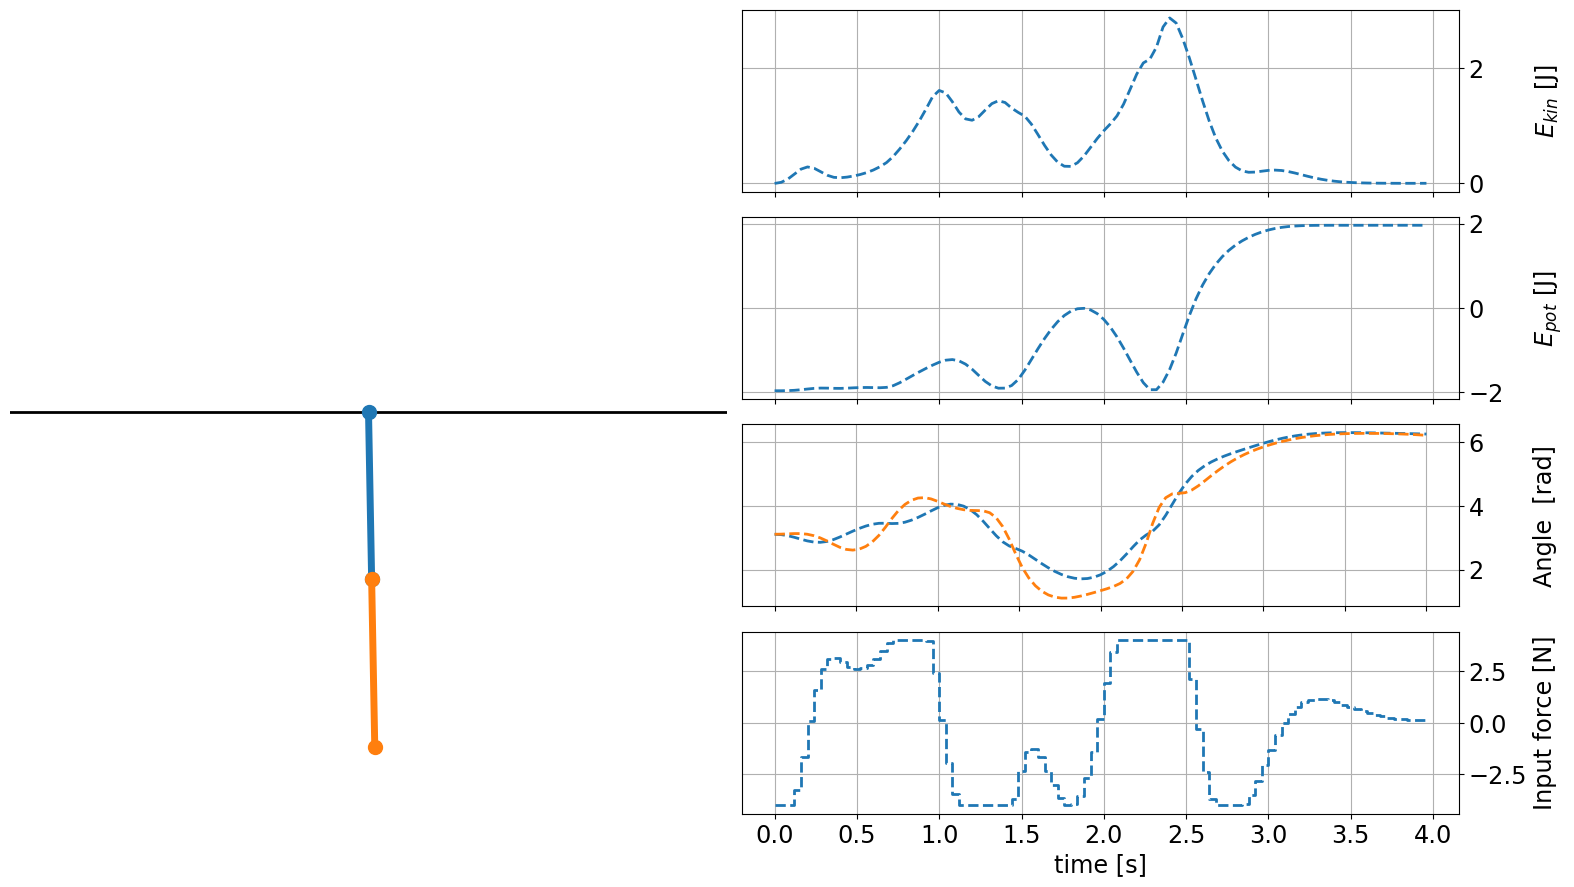

In [26]:
line1, line2 = pendulum_bars(x0)
bar1[0].set_data(line1[0],line1[1])
bar2[0].set_data(line2[0],line2[1])
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()

fig

The open-loop prediction looks perfectly fine! We see that within the horizon the potential energy settles on a plateau greater than zero, while the kinetic energy becomes zero. This indicates our desired up-up position. Both angles seem to reach $2\pi$.

### Run closed-loop

The closed-loop system is now simulated for 100 steps (and the ouput of the optimizer is suppressed):

In [27]:
%%capture
# Quickly reset the history of the MPC data object.
mpc.reset_history()

n_steps = 100
for k in range(n_steps):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

### Results

The next cell converts the results of the closed-loop MPC simulation into a gif (might take a few minutes):

In [29]:
from matplotlib.animation import FuncAnimation, FFMpegWriter, ImageMagickWriter

# The function describing the gif:
x_arr = mpc.data['_x']
def update(t_ind):
    line1, line2 = pendulum_bars(x_arr[t_ind])
    bar1[0].set_data(line1[0],line1[1])
    bar2[0].set_data(line2[0],line2[1])
    mpc_graphics.plot_results(t_ind)
    mpc_graphics.plot_predictions(t_ind)
    mpc_graphics.reset_axes()
    

anim = FuncAnimation(fig, update, frames=n_steps, repeat=False)
gif_writer = ImageMagickWriter(fps=20)
# anim.save('anim_dip.gif', writer=gif_writer)

The result is shown below, where solid lines are the recorded trajectories and dashed lines are the predictions of the scenarios:

![animdip](anim_dip.gif "Animation double inverted pendulum being errected.")

## Controller with obstacle avoidance

To make the example even more interesting it is possible to add obstacles and include a set-point tracking task, where the pendulum must be errect at a desired location. 

**Please note** that the animation below now shows the pendulum position (of the cart) as well as the desired setpoint instead of the angles.

![animdipobs](anim_dip_obstacles.gif "Animation of double inverteded pendulum being errected and avoiding an obstacle. Including a setpoint change from the left side of the obstacle to the right side of the obstacle.")

The code to create this animation is included in the **do-mpc** example files and is just an extension of the example shown above.

The necessary changes include the detection of obstacle intersection and an adapted objective function that includes the set-point tracking for the position.